In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
from tqdm.notebook import tqdm
from pathlib import Path
from multiprocessing import Pool
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchtext

import timm
import fastai.text.all as fastai
from fastai.callback.schedule import Learner

# from torch.utils.tensorboard import SummaryWriter
from tensorboardX import SummaryWriter
%load_ext tensorboard

import spacy
import re
import nltk

seed = 42
np.random.seed(seed)
torch.manual_seed(seed + 1)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed + 2)

In [2]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = 'mps'
    else:
        device = 'cpu'
    return device

device = get_device()

print(f'device: {device}')

device: cuda


In [63]:
checkpoint = Path.cwd() / 'models' / 'checkpoint.pth'

In [3]:
def get_optimizer(model, optimizer='sgd', lr=0.001, weight_decay=0, momentum=0, betas=(0.9, 0.999), eps=1e-8):
    if optimizer == 'sgd':
        opt = torch.optim.SGD(
            model.parameters(),
            lr=lr, 
            weight_decay=weight_decay, 
            momentum=momentum
        )
    if optimizer == 'adam':
        opt = torch.optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            betas=betas,
            eps=eps
        )
    return opt

def train_classifier(train_data, model, opt, loss_fn, test_data=None, num_epochs=10, plot_loss=True, batch_size=32,
                     tensorboard=False, print_stats=True, show_batches_bar=False, shuffle=True, scheduler=None,
                     print_every=1, n_grad_accums=1, use_multi_gpus=False):
    if tensorboard:
        writer = SummaryWriter()
    losses = []
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    if test_data is not None:
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    if use_multi_gpus:
        orig_model = model
        model = nn.DataParallel(model)
    for epoch in tqdm(range(num_epochs)):
        model = model.train()
        batch_losses = []
        batch_correct = []
        iterator = tqdm(train_loader, leave=False) if show_batches_bar else train_loader
        for i, (X, y) in enumerate(iterator):
            X = X.to(device)
            y = y.to(device)
            yhat = model(X)
            loss = loss_fn(yhat, y).mean() # mean is for multi-gpu losses, avg them together
            loss /= n_grad_accums # rescale loss for grad accumulation
            loss.backward()
            if i % n_grad_accums == 0: # only step when every n_grad_accums grad updates
                opt.step()
                opt.zero_grad()
            batch_losses.append(float(loss)* batch_size)
            batch_correct.append(float((yhat.argmax(dim=1) == y).sum().cpu()))
        train_loss = sum(batch_losses) / len(train_data)
        train_acc = sum(batch_correct) / len(train_data)
        losses.append(train_loss)
        
        if test_data is not None:
            model = model.eval()
            opt.zero_grad()
            batch_losses = []
            batch_correct = []
            iterator = tqdm(test_loader, leave=False) if show_batches_bar else test_loader
            for X, y in iterator:
                X = X.to(device)
                y = y.to(device)
                yhat = model(X)
                loss = loss_fn(yhat, y).mean()
                batch_losses.append(float(loss) * batch_size)
                batch_correct.append(float((yhat.argmax(dim=1) == y).sum().cpu()))
            test_loss = sum(batch_losses) / len(test_data)
            test_acc = sum(batch_correct) / len(test_data)
        else:
            test_loss = -999
            test_acc = -999
            
        if scheduler is not None:
            scheduler.step()

        if tensorboard:
            writer.add_scalar("Training Loss", train_loss, epoch+1)
            writer.add_scalar("Training Accuracy", train_acc, epoch+1)
            writer.add_scalar("Test Loss", test_loss, epoch+1)
            writer.add_scalar("Test Accuracy", test_acc, epoch+1)
        if print_stats and epoch % print_every == 0:
            s1 = f'epoch: {epoch: <3}   ' 
            s2 = f'train loss: {round(train_loss, 4): <6}   train acc: {round(train_acc, 4): <6}   ' 
            s3 = f'test loss: {round(test_loss, 4): <6}   test acc: {round(test_acc, 4): <6}'
            print(s1 + s2 + s3)
    if plot_loss:
        plt.plot(range(len(losses)), losses)
        plt.show()
    if tensorboard:
        writer.flush()
        writer.close()
    model = model if not use_multi_gpus else orig_model
    return model

class Dataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
# def text_from_iter(data_iter):
#     corpus = []
#     for text in data_iter:
#         corpus.append(text)
#     return corpus

# train_iter = torchtext.datasets.WikiText103(split='train')
# val_iter = torchtext.datasets.WikiText103(split='valid')
# test_iter = torchtext.datasets.WikiText103(split='test')

# train_text = text_from_iter(train_iter) + text_from_iter(val_iter)
# test_text = text_from_iter(test_iter)

# tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
# train_tokens = (tokenizer(doc) for doc in tqdm(train_text))
# test_tokens = (tokenizer(doc) for doc in tqdm(test_text))

# vocab = torchtext.vocab.build_vocab_from_iterator(train_tokens, max_tokens=10000, specials=['<unk>', '<pad>'], min_freq=50)
# vocab.set_default_index(vocab["<unk>"])
# stoi = vocab.get_stoi()
# itos = vocab.get_itos()

# max_tokens = 256
# train_tokens = [doc[:max_tokens] for doc in train_tokens if len(doc) > 5]
# test_tokens = [doc[:max_tokens] for doc in test_tokens if len(doc) > 5]

# Machine Translation: English to French

In [5]:
nlp_en = spacy.load('en_core_web_sm')
nlp_fr = spacy.load('fr_core_news_sm')
tokenizer_en = torchtext.data.utils.get_tokenizer(nlp_en)
tokenizer_fr = torchtext.data.utils.get_tokenizer(nlp_fr)

In [6]:
path = Path.home() / 'data' / 'machine-translation' / 'eng-fra.txt'
text = path.read_text().split('\n')
text = [t.replace('\u202f', '').split('\t') for t in text]
text = [doc for doc in text if len(doc) == 2]
len(text), text[:10]

(135842,
 [['Go.', 'Va !'],
  ['Run!', 'Cours!'],
  ['Run!', 'Courez!'],
  ['Wow!', 'Ça alors!'],
  ['Fire!', 'Au feu !'],
  ['Help!', "À l'aide!"],
  ['Jump.', 'Saute.'],
  ['Stop!', 'Ça suffit!'],
  ['Stop!', 'Stop!'],
  ['Stop!', 'Arrête-toi !']])

In [7]:
def apply_tokenizer(doc, tokenizer):
    return [token.text.lower() for token in tokenizer(doc)]

def get_tokens(doc):
    tokens_en = apply_tokenizer(doc[0], tokenizer_en)
    tokens_fr = apply_tokenizer(doc[1], tokenizer_fr)
    return tokens_en, tokens_fr

with Pool(processes=8) as pool:
    tokens = [x for x in tqdm(pool.imap(get_tokens, text), total=len(text))]

  0%|          | 0/135842 [00:00<?, ?it/s]

In [8]:
max_tokens = 10

tokens_en = [toks for toks, _ in tokens if len(toks) <= max_tokens and len(_) <= max_tokens]
tokens_fr = [toks for _, toks in tokens if len(toks) <= max_tokens and len(_) <= max_tokens]
len(tokens_en), len(tokens_fr)

(105945, 105945)

In [9]:
list(zip(tokens_en, tokens_fr))[:10]

[(['go', '.'], ['va', '!']),
 (['run', '!'], ['cours', '!']),
 (['run', '!'], ['courez', '!']),
 (['wow', '!'], ['ça', 'alors', '!']),
 (['fire', '!'], ['au', 'feu', '!']),
 (['help', '!'], ['à', "l'", 'aide', '!']),
 (['jump', '.'], ['saute', '.']),
 (['stop', '!'], ['ça', 'suffit', '!']),
 (['stop', '!'], ['stop', '!']),
 (['stop', '!'], ['arrête', '-', 'toi', '!'])]

In [25]:
vocab_en = torchtext.vocab.build_vocab_from_iterator(tokens_en, specials=['<bos>', '<eos>', '<unk>', '<pad>'],
                                                     max_tokens=5000, special_first=True)
vocab_en.set_default_index(vocab_en["<unk>"])
stoi_en = vocab_en.get_stoi()
itos_en = vocab_en.get_itos()

vocab_fr = torchtext.vocab.build_vocab_from_iterator(tokens_fr, specials=['<bos>', '<eos>', '<unk>', '<pad>'],
                                                     max_tokens=5000, special_first=True)
vocab_fr.set_default_index(vocab_fr["<unk>"])
stoi_fr = vocab_fr.get_stoi()
itos_fr = vocab_fr.get_itos()

len(vocab_en), len(vocab_fr)

(5000, 5000)

In [26]:
nums_en = [vocab_en(toks) for toks in tokens_en]
nums_fr = [vocab_fr(toks) for toks in tokens_fr]

In [27]:
def pad_tokens(nums, seq_len, stoi, bos_token='<bos>', eos_token='<eos>', pad_token='<pad>'):
    nums = [stoi[bos_token]] + nums + [stoi[eos_token]]
    nums = nums + [stoi[pad_token]] * (seq_len - len(nums))
    return nums

seq_len = max_tokens + 2 # including <bos>, <eos> around tokens of length 10 already
nums_en_padded = [pad_tokens(num, seq_len, stoi_en) for num in nums_en]
nums_fr_padded = [pad_tokens(num, seq_len, stoi_fr) for num in nums_fr]

In [28]:
nums_en_padded[0], nums_fr_padded[0]

([0, 49, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3],
 [0, 120, 31, 1, 3, 3, 3, 3, 3, 3, 3, 3])

# Seq2Seq Models

- Learnings a mapping from a sequence $x_1,\cdots,x_T$ to a new sequence $y_1,\cdots,y_{T'}$.
- The stereotypical application is machine translation, where text in one language is translated to language in another language. For example, translating French `le chat est noir` to English `the cat is black`. 
- Other examples include named entity recognition (NER), part of speech tagging (POS), or speech recognition (audio to text).
- Typically an encoder-decoder architecture is used. The **encoder** is a sequence model (e.g. an RNN) that takes a sequence and outputs a hidden state vector. This, along with the output sequence, then gets fed to a **decoder**, a different sequence model that uses the encoder hidden states and the output sequences to produce a predition sequence.

![Seq2Seq](https://pytorch.org/tutorials/_images/seq2seq.png)

**Teacher Forcing**
- To help the model learn to predict the output sequence better, a technique called teacher forcing is often used.
- One defines some teacher forcing probability $p_{TF}$. When each output prediction $\hat y_t$ gets made, instead of passing it directly into the input, one *instead* uses the *ground truth* output $y_t$ if $rand() < p_{TF}$.
- This can help the model learn to output coherent sequences better, but using it too much can make the model rely on the ground truth outputs, even though at test time such outputs may not be available.

In [29]:
class Encoder(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, n_layers, rnn=nn.GRU, dropout=0.5):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.emb = nn.Embedding(input_size, emb_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.rnn = rnn(emb_size, hidden_size, n_layers, batch_first=True, dropout=dropout)
    
    def forward(self, x, h):
        x = self.emb(x)
        x = self.dropout(x)
        x = self.relu(x)
        x, h = self.rnn(x, h)
        return x, h
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)
    
class Decoder(nn.Module):
    def __init__(self, output_size, emb_size, hidden_size, n_layers, rnn=nn.GRU, dropout=0.5):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.emb = nn.Embedding(output_size, emb_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.rnn = rnn(emb_size, hidden_size, n_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, y, h):       
        y = self.emb(y)
        y = self.dropout(y)
        y = self.relu(y)
        y, h = self.rnn(y, h)
        y = self.fc(y)
        return y, h
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)
    
class Seq2SeqModel(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, output_size, n_layers=1, bos=0, rnn=nn.GRU, dropout=0.5):
        super().__init__()
        self.encoder = Encoder(input_size, emb_size, hidden_size, n_layers, rnn=rnn, dropout=dropout)
        self.decoder = Decoder(output_size, emb_size, hidden_size, n_layers, rnn=rnn, dropout=dropout)
        self.output_size = output_size
        self.bos = bos
    
    def forward(self, X, h, Y=None, teacher_forcing=0):
        _, h = self.encoder(X, h)
        seq_len, batch_size = X.shape[1], X.shape[0]
        Y = Y.permute(1, 0) if Y is not None else None
        Yhat = torch.empty(seq_len, batch_size, self.output_size)
        y_prev = torch.tensor([self.bos] * batch_size).reshape(batch_size, 1).to(device)
        for i in range(seq_len):
            y_out, h = self.decoder(y_prev, h)
            y_prev = y_out.argmax(dim=-1).detach()
            y_prev = Y[i][:, None] if np.random.rand() < teacher_forcing else y_prev
            Yhat[i] = y_out.permute(1, 0, 2)
        Yhat = Yhat.permute(1, 0, 2)
        return Yhat.to(device), h.to(device)
    
    def init_hidden(self, batch_size):
        return self.encoder.init_hidden(batch_size)

In [30]:
vocab_size = 1000
batch_size = 16
X = torch.randint(0, vocab_size, size=(batch_size,10)).to(device)
Y = torch.randint(0, vocab_size, size=(batch_size,10)).to(device)

model = Seq2SeqModel(vocab_size, 50, 100, vocab_size, n_layers=2, bos=1).to(device)
h = model.init_hidden(batch_size)
Yhat, h = model(X, h, Y, teacher_forcing=0.5)
X.shape, h.shape, Y.shape, Yhat.shape

(torch.Size([16, 10]),
 torch.Size([2, 16, 100]),
 torch.Size([16, 10]),
 torch.Size([16, 10, 1000]))

In [31]:
y = Y.reshape(batch_size * 10,).to(device)
yhat = Yhat.reshape(batch_size * 10, -1).to(device)
loss_fn = nn.CrossEntropyLoss()
loss_fn(yhat, y)

tensor(6.9159, device='cuda:0', grad_fn=<NllLossBackward0>)

In [41]:
def train_seq2seq(train_data, model, opt, loss_fn, test_data=None, num_epochs=10, plot_loss=True, batch_size=32,
                  tensorboard=False, print_stats=True, show_batches_bar=False, shuffle=True, scheduler=None,
                  print_every=1, n_grad_accums=1, use_multi_gpus=False, grad_clip=None, teacher_forcing=0.5):
    if tensorboard:
        writer = SummaryWriter()
    losses = []
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    if test_data is not None:
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    if use_multi_gpus:
        orig_model = model
        model = nn.DataParallel(model)
       
    for epoch in tqdm(range(num_epochs)):
        model = model.train()
        batch_losses = []
        iterator = tqdm(train_loader, leave=False) if show_batches_bar else train_loader
        # if not specified, use heavy teacher forcing early in training and decay it linearly to zero
        teacher_forcing = (1 - epoch / num_epochs) * teacher_forcing
        for i, (X, Y) in enumerate(iterator):
            X = X.to(device).long()
            Y = Y.to(device).long()
            bs, bptt = Y.shape[0], Y.shape[1]
            h = model.init_hidden(bs)
            Yhat, h = model(X, h, Y=Y, teacher_forcing=teacher_forcing)
            y = Y.reshape(bs * bptt,)
            yhat = Yhat.reshape(bs * bptt, -1)
            loss = loss_fn(yhat, y).mean() # mean is for multi-gpu losses, avg them together
            loss /= n_grad_accums # rescale loss for grad accumulation
            loss.backward()
            if grad_clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            if i % n_grad_accums == 0: # only step when every n_grad_accums grad updates
                opt.step()
                opt.zero_grad()
            batch_losses.append(float(loss)* batch_size)
        train_loss = sum(batch_losses) / len(train_data)
        losses.append(train_loss)
        
        if test_data is not None:
            model = model.eval()
            opt.zero_grad()
            batch_losses = []
            iterator = tqdm(test_loader, leave=False) if show_batches_bar else test_loader
            for X, Y in iterator:
                X = X.to(device)
                Y = Y.to(device)
                bs, bptt = Y.shape[0], Y.shape[1]
                h = model.init_hidden(bs)
                Yhat, h = model(X, h, Y=Y)
                y = Y.reshape(bs * bptt,)
                yhat = Yhat.reshape(bs * bptt, -1)
                loss = loss_fn(yhat, y).mean()
                batch_losses.append(float(loss) * batch_size)
            test_loss = sum(batch_losses) / len(test_data)
        else:
            test_loss = -999
            
        if scheduler is not None:
            scheduler.step()

        if tensorboard:
            writer.add_scalar("Training Loss", train_loss, epoch+1)
            writer.add_scalar("Test Loss", test_loss, epoch+1)
        if print_stats and (epoch % print_every == 0) or (epoch == num_epochs - 1):
            s1 = f'epoch: {epoch: <3}   ' 
            s2 = f'train loss: {round(train_loss, 4): <6}   test loss: {round(test_loss, 4): <6}' 
            print(s1 + s2)
    if plot_loss:
        plt.plot(range(len(losses)), losses)
        plt.show()
    if tensorboard:
        writer.flush()
        writer.close()
    model = model if not use_multi_gpus else orig_model
    return model

In [33]:
idx_train, idx_test = train_test_split(range(len(nums_en_padded)), train_size=0.9, shuffle=True, random_state=seed)

X = torch.tensor(nums_en_padded).long().to(device)
Y = torch.tensor(nums_fr_padded).long().to(device)

X_train = X[idx_train]
Y_train = Y[idx_train]
X_test = X[idx_test]
Y_test = Y[idx_test]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

(torch.Size([95350, 12]),
 torch.Size([95350, 12]),
 torch.Size([10595, 12]),
 torch.Size([10595, 12]))

In [53]:
samples = 40000

train_data = Dataset(X_train[:samples], Y_train[:samples])
test_data = Dataset(X_test, Y_test)

In [54]:
vocab_size_en = len(vocab_en)
vocab_size_fr = len(vocab_fr)
emb_size = 256
hidden_size = 256
bos_out = stoi_fr['<bos>'] # output <bos> token

/home/paperspace/miniconda3/envs/main/lib/python3.10/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/60 [00:00<?, ?it/s]

epoch: 0     train loss: 5.3814   test loss: 4.7938
epoch: 1     train loss: 4.4554   test loss: 4.719 
epoch: 2     train loss: 4.3656   test loss: 4.6373
epoch: 3     train loss: 4.2953   test loss: 4.6132
epoch: 4     train loss: 4.2484   test loss: 4.5877
epoch: 5     train loss: 4.2042   test loss: 4.5748
epoch: 6     train loss: 4.1269   test loss: 4.3892
epoch: 9     train loss: 3.823    test loss: 4.0747
epoch: 10    train loss: 3.7534   test loss: 3.9602
epoch: 11    train loss: 3.6776   test loss: 3.8682
epoch: 12    train loss: 3.6277   test loss: 3.8047
epoch: 13    train loss: 3.5571   test loss: 3.7283
epoch: 14    train loss: 3.4928   test loss: 3.6622
epoch: 15    train loss: 3.4363   test loss: 3.6463
epoch: 16    train loss: 3.3769   test loss: 3.545 
epoch: 17    train loss: 3.3221   test loss: 3.4915
epoch: 18    train loss: 3.2641   test loss: 3.4329
epoch: 19    train loss: 3.1938   test loss: 3.376 
epoch: 20    train loss: 3.1392   test loss: 3.3419
epoch: 21   

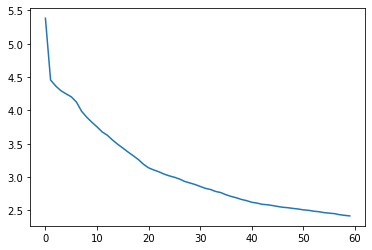

In [55]:
model = Seq2SeqModel(vocab_size_en, emb_size, hidden_size, vocab_size_fr, n_layers=1, dropout=0.1).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=stoi_en['<pad>']) # ignore loss from <pad> tokens
opt = get_optimizer(model, optimizer='adam', lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.5)
model = train_seq2seq(train_data, model, opt, loss_fn, num_epochs=60, batch_size=1024, grad_clip=5., print_every=1, 
                      test_data=test_data, teacher_forcing=0.5, show_batches_bar=False, scheduler=scheduler)

In [56]:
def predict(model, english):
    x = [token.text.lower() for token in tokenizer_en(english)]
    x = vocab_en(x)
    x = pad_tokens(x, seq_len, vocab_en.get_stoi())
    x = torch.tensor(x).long().to(device)[None, :]
    h = model.init_hidden(1)
    yhat, h = model(x, h)
    yhat = yhat.argmax(-1).long().detach().cpu().flatten()
    french = [vocab_fr.get_itos()[y] for y in yhat]
    return ' '.join(french).replace('<pad>', '').replace('<eos>', '').replace('<bos>', '').strip()

In [59]:
predict(model, 'Who are you?')

'qui est - ?'

In [60]:
torch.save(model.state_dict(), checkpoint)
model = Seq2SeqModel(vocab_size_en, emb_size, hidden_size, vocab_size_fr, n_layers=1, dropout=0.1).to(device)
model.load_state_dict(torch.load(checkpoint))

**Image to Text Models**
- Maps an image to a sequence of text output. The stereotypical example is image captioning, where one feeds in an image and asks the model to "describe" what the image is in words.
- Typically a CNN model is used to get a feature map of the image, which is then fed as an input into a sequence model decoder to output text.

**Beam Search**
- In a seq2seq model, the model tries to learn $p(y_1,\cdots,y_{T'}|x_1,\cdots,x_T)$. In many applications, one doesn't want to sample from this distribution, but to find the *most likely* sequence $\hat y_1, \cdots, \hat y_{T'}$, e.g. in machine translation where one wants the *best* possible translation.
- The naive way of outputing a prediction is a "greedy search". This approach just uses the argmax of each predicted $\hat y_t$ to make a prediction. Greedy searches aren't generally optimal, in the sense of getting the argmax of the *joint distribution*. In the case of seq2seq, the greedy search can overly focus on the earlier inputs, causing it to miss the big picture.
- Beam search is a way around this. It's an approximate algorithm for finding the max of a set of sequences sampled from a joint distribution, i.e. finding $\hat y = \text{argmax} p(y_1,\cdots,y_{T'}|x_1,\cdots,x_T)$.

**Attention Models**
- Vanilla seq2seq models tend not to work as well for longer sequences, e.g. 30+ token sequences. This is in essence because they have to remember the entire input to pass into the decoder and decide what the output should be. 
- Attention models get around this problem by allowing the output to focus just on the local input context (e.g. the first few words) by using a learned "attention layer" to learn the probabilities of any one input affecting that output. That way, the decoder can only focus on a specific range of inputs, not the whole sequence.
- Example: Consider the translation `Jane visite l'Afrique en septembre` -> `Jane visits Africa in September`. In predicting the output token `Jane`, the model will probably want to look most at the beginning of the input, i.e. `Jane`. So maybe the input tokens should be weighted, e.g. `Jane: 0.9, visite: 0.6, l'Afrique: 0.2, en: 0.1, septembre: 0.1`. That is, the model should focus 90% of its weight on the first word `Jane` when predicting the output word `Jane`.
- Blah